# Discretisation methods

In [147]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tslearn.piecewise import SymbolicAggregateApproximation as SAXTSLearn
from pyts.approximation import SymbolicAggregateApproximation as SAXPyts
from pyts.classification import SAXVSM
from pyts.bag_of_words import BagOfWords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import mode

np.random.seed(123)

%run ../sys_configs.ipynb

## Introduction

Discretisation is commonly applied to time series as a pre-processing step for subsequent methods. These follow up methods typically slide windows over the time series, creating *words* from consecutive sequences of discretised *letters.* This transforms the problem to one akin to sentiment classification based on a corpus of text data, and the approaches described below reflect this.

Begin by reading in the sampled data produced by window method 1.

In [3]:
with open('../data/1s_train.npy', 'rb') as f:
    x1s_train = np.load(f)
    y1s_train = np.load(f)
sz, dim = x1s_train.shape[1:]
    
with open('../data/1s_val.npy', 'rb') as f:
    x1s_val = np.load(f)
    y1s_val = np.load(f)

## Approach 1: Symbolic Aggregation approXimation + Bag of Patterns

### Approach

Symbolic Aggregation approXimation (SAX) was introduced in [1]. It maps each observation to bins whose edges are uniform or based on quantiles. In this problem instance, the GAR data is standardised to have zero mean and unit variance so the bin edges are defined from quantiles of the standard normal distribution. Then, the Bag of Patterns algorithm which was introduced in [2] slides a window over the discretised time series and at each increment extracts a word of the window length. The frequency of each word in the discretised time series then gets computed, producing a dictionary of word counts. This dictionary amounts to a bag of features where the features are the *words* and the counts are the *word counts*. Traditional classifiers like nearest neighbours or logistic regression can then be built on top of the bag of features.

Next, one can apply the Bag-of-Patterns algorithm covered in Lin et al. (2012) to slide windows over each time series, discretising each observation to form words. One then counts the occurrences of each word in each time series, analagous to a Count Vectoriser; at this point NN can be applied.

### 1.1: Train & Predict (6D)

In the first approach, create words with length 6 by discretising the time series and then concatenating the components of the sensor data. These words form the vocabulary for the CountVectoriser. Because we use a cardinality of 8 for each component, there are $8^{6} = 262144$ possible words.

In [53]:
# SAX transform
n_sax_symbols = 8
n_paa_segments = 25
sax = SAXTSLearn(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)

In [54]:
# Fit on the train data. Then discretise the train data, then the validation data
x1s_train_d = sax.fit_transform(x1s_train)
x1s_val_d = sax.transform(x1s_val)

# Inverse transform the discretised train and validation data for the purposes of plotting
x1s_train_d_inv = sax.inverse_transform(x1s_train_d)
x1s_test_d_inv = sax.inverse_transform(x1s_val_d)

In [5]:
# Convert the train and validation data to str
x1s_train_d = x1s_train_d.astype(str)
x1s_val_d = x1s_val_d.astype(str)
print("The shape of each sample of train data is now {}".format(x1s_train_d.shape[1:]))

The shape of each sample of train data is now (25, 6)


In [6]:
# Concatenate the words along the third dimension (axis=2)
x1s_train_d = np.apply_along_axis(lambda x: ''.join(x), 2, x1s_train_d)
x1s_val_d = np.apply_along_axis(lambda x: ''.join(x), 2, x1s_val_d)
print("The shape of each sample of train data is now {}".format(x1s_train_d.shape[1:]))

The shape of each sample of train data is now (25,)


In [7]:
# Transform the words into a document-term matrix
vectoriser = CountVectorizer()
x1s_train_vec = vectoriser.fit_transform([' '.join(word) for word in x1s_train_d])
x1s_val_vec = vectoriser.transform([' '.join(word) for word in x1s_val_d])

In [8]:
x1s_train_vec = np.asarray(x1s_train_vec.todense())
x1s_val_vec = np.asarray(x1s_val_vec.todense())

In [9]:
# Train a k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors=4, metric = "l1")
knn.fit(x1s_train_vec, y1s_train)

# Evaluate the classifier
y_pred = knn.predict(x1s_val_vec)
accuracy = accuracy_score(y1s_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.06415094339622641


### 1.2: Train & Predict (6 x 1D)

In [4]:
# Obtain each of the 6 components for both the train and validation data
train_acc_x = x1s_train[:, :, 0]
train_acc_y = x1s_train[:, :, 1]
train_acc_z = x1s_train[:, :, 2]
train_gyr_x = x1s_train[:, :, 3]
train_gyr_y = x1s_train[:, :, 4]
train_gyr_z = x1s_train[:, :, 5]

val_acc_x = x1s_val[:, :, 0]
val_acc_y = x1s_val[:, :, 1]
val_acc_z = x1s_val[:, :, 2]
val_gyr_x = x1s_val[:, :, 3]
val_gyr_y = x1s_val[:, :, 4]
val_gyr_z = x1s_val[:, :, 5]

In [5]:
n_bins = 8
bow = BagOfWords(window_size=10, 
                 word_size=5, 
                 n_bins=8, 
                 strategy="quantile", 
                 numerosity_reduction=True, 
                 window_step=10
                )
bow_acc_x = bow
bow_acc_y = bow
bow_acc_z = bow
bow_gyr_x = bow
bow_gyr_y = bow
bow_gyr_z = bow

In [6]:
train_acc_x_d = bow_acc_x.fit_transform(X = train_acc_x, y = y1s_train)
train_acc_y_d = bow_acc_y.fit_transform(X = train_acc_y, y = y1s_train)
train_acc_z_d = bow_acc_z.fit_transform(X = train_acc_z, y = y1s_train)
train_gyr_x_d = bow_gyr_x.fit_transform(X = train_gyr_x, y = y1s_train)
train_gyr_y_d = bow_gyr_y.fit_transform(X = train_gyr_y, y = y1s_train)
train_gyr_z_d = bow_gyr_z.fit_transform(X = train_gyr_z, y = y1s_train)

val_acc_x_d = bow_acc_x.transform(X = val_acc_x)
val_acc_y_d = bow_acc_y.transform(X = val_acc_y)
val_acc_z_d = bow_acc_z.transform(X = val_acc_z)
val_gyr_x_d = bow_gyr_x.transform(X = val_gyr_x)
val_gyr_y_d = bow_gyr_y.transform(X = val_gyr_y)
val_gyr_z_d = bow_gyr_z.transform(X = val_gyr_z)

In [7]:
# Transform the words into a document-term matrix
vectoriser_acc_x = CountVectorizer()
vectoriser_acc_y = CountVectorizer()
vectoriser_acc_z = CountVectorizer()
vectoriser_gyr_x = CountVectorizer()
vectoriser_gyr_y = CountVectorizer()
vectoriser_gyr_z = CountVectorizer()

In [8]:
train_acc_x_counts = vectoriser_acc_x.fit_transform(train_acc_x_d).toarray()
train_acc_y_counts = vectoriser_acc_y.fit_transform(train_acc_y_d).toarray()
train_acc_z_counts = vectoriser_acc_z.fit_transform(train_acc_z_d).toarray()
train_gyr_x_counts = vectoriser_gyr_x.fit_transform(train_gyr_x_d).toarray()
train_gyr_y_counts = vectoriser_gyr_y.fit_transform(train_gyr_y_d).toarray()
train_gyr_z_counts = vectoriser_gyr_z.fit_transform(train_gyr_z_d).toarray()

In [9]:
val_acc_x_counts = vectoriser_acc_x.transform(val_acc_x_d).toarray()
val_acc_y_counts = vectoriser_acc_y.transform(val_acc_y_d).toarray()
val_acc_z_counts = vectoriser_acc_z.transform(val_acc_z_d).toarray()
val_gyr_x_counts = vectoriser_gyr_x.transform(val_gyr_x_d).toarray()
val_gyr_y_counts = vectoriser_gyr_y.transform(val_gyr_y_d).toarray()
val_gyr_z_counts = vectoriser_gyr_z.transform(val_gyr_z_d).toarray()

In [10]:
train_counts = np.hstack((train_acc_x_counts,
                          train_acc_y_counts,
                          train_acc_z_counts,
                          train_gyr_x_counts,
                          train_gyr_y_counts,
                          train_gyr_z_counts
                         ))
val_counts = np.hstack((val_acc_x_counts,
                        val_acc_y_counts,
                        val_acc_z_counts,
                        val_gyr_x_counts,
                        val_gyr_y_counts,
                        val_gyr_z_counts
                       ))

This is very high dimensional data where there are more dimensions than samples. This interferes with the non-uniqueness required by some machine learning methods. We first experiment with Random Forest and K-Nearest Neighbours directly on the train data, then experiment with reducing the dimensionality with PCA.

#### 1.2.1: K-Nearest Neighbours

In [30]:
# Train a k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors=4, metric = "l1")
knn.fit(train_counts, y1s_train)

# Evaluate the classifier
y_pred = knn.predict(val_counts)
accuracy = accuracy_score(y1s_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.04905660377358491


#### 1.2.2: Random Forest

In [32]:
rfc = RandomForestClassifier(n_estimators=10000, criterion='gini', max_depth=4, min_samples_split=3, max_features='log2')
rfc.fit(train_counts, y1s_train)

y_pred = rfc.predict(val_counts)

accuracy = accuracy_score(y1s_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.08490566037735849


#### 1.2.3: PCA + Logistic Regression

In [36]:
pca = PCA(n_components = 25)
pca.fit(train_counts)

PCA(n_components=25)

In [39]:
train_counts_pca = pca.transform(train_counts)
val_counts_pca = pca.transform(val_counts)

In [40]:
rfc = RandomForestClassifier(n_estimators=10000, criterion='gini', max_depth=4, min_samples_split=3, max_features='log2')
rfc.fit(train_counts_pca, y1s_train)

y_pred = rfc.predict(val_counts_pca)

accuracy = accuracy_score(y1s_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.06792452830188679


### 1.3: Visualisations

Below, we visualise how SAX discretises a time series.

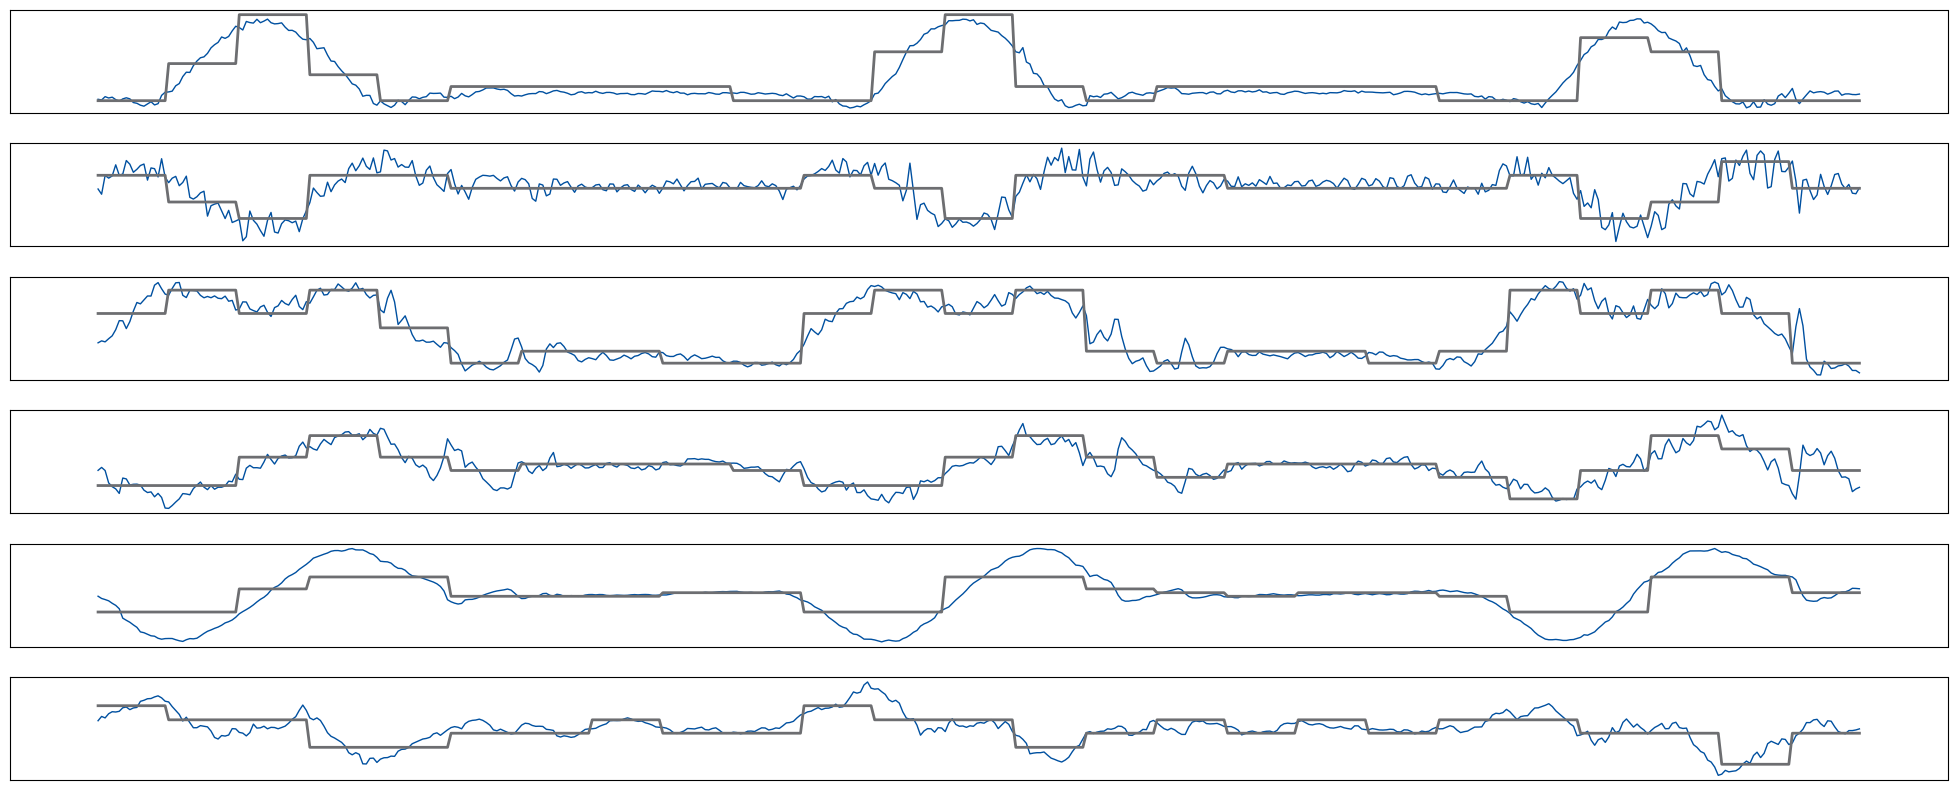

In [96]:
#fig, axes = plt.subplots(figsize = (12, 5))
N = len(x1s_train)
n_rows = 6
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(25,10))
fig.subplots_adjust(hspace=0.3, wspace=0.05)
    
random_idx = np.random.choice(N, 1, replace=False)

data = {
    "Acceleration (x)": (train_acc_x, x1s_train_d_inv[:, :, 0]),
    "Acceleration (y)": (train_acc_y, x1s_train_d_inv[:, :, 1]),
    "Acceleration (z)": (train_acc_z, x1s_train_d_inv[:, :, 2]),
    "Gyroscope (x)": (train_gyr_x, x1s_train_d_inv[:, :, 3]),
    "Gyroscope (y)": (train_gyr_y, x1s_train_d_inv[:, :, 4]),
    "Gyroscope (z)": (train_gyr_z, x1s_train_d_inv[:, :, 5])
}

for row, (key, val) in enumerate(data.items()):
    sample = val[0][random_idx].flatten()
    sample_d = val[1][random_idx].flatten()
    
    axes[row].plot(sample, color=scale_rgb(COLOURS.get("primary-color")), label=key, linewidth = 1)
    axes[row].plot(sample_d, color=scale_rgb(COLOURS.get("accent-grey-dark-1")), label=key, linewidth = 2)
    
    axes[row].set_xticks([])
    axes[row].set_xlabel('')

    axes[row].set_yticks([])
    axes[row].set_ylabel('')

## Approach 2: SAX - VSM

Introduced in [3], Symbolic Aggregation approXimation in Vector Space Model (SAX-VSM) computes a Term Frequency - Inverse Document Frequency (TF-IDF) matrix. Total counts of each word are computed by class, then normalised by the number of
classes within which the word was featured, ensuring common words have less predictive power and rare words associated with a single class have higher predictive power. Inference is performed by computing the cosine similarity between a new time series’ TF-IDF vector and each class in the TF-IDF matrix.

In [169]:
# Fit a SAX VSM model to each component
saxvsm_acc_x = SAXVSM(window_size=15, word_size=8, n_bins=10, strategy="quantile")
saxvsm_acc_y = SAXVSM(window_size=15, word_size=8, n_bins=10, strategy="quantile")
saxvsm_acc_z = SAXVSM(window_size=15, word_size=8, n_bins=10, strategy="quantile")
saxvsm_gyr_x = SAXVSM(window_size=15, word_size=8, n_bins=10, strategy="quantile")
saxvsm_gyr_y = SAXVSM(window_size=15, word_size=8, n_bins=10, strategy="quantile")
saxvsm_gyr_z = SAXVSM(window_size=15, word_size=8, n_bins=10, strategy="quantile")

In [170]:
saxvsm_acc_x.fit(train_acc_x, y1s_train)
saxvsm_acc_y.fit(train_acc_y, y1s_train)
saxvsm_acc_z.fit(train_acc_z, y1s_train)
saxvsm_gyr_x.fit(train_gyr_x, y1s_train)
saxvsm_gyr_y.fit(train_gyr_y, y1s_train)
saxvsm_gyr_z.fit(train_gyr_z, y1s_train)

SAXVSM(n_bins=10, strategy='quantile', window_size=15, word_size=8)

In [171]:
# Predict the classes from each SAX VSM model individually
train_saxvsm_acc_x = saxvsm_acc_x.predict(train_acc_x)
train_saxvsm_acc_y = saxvsm_acc_y.predict(train_acc_y)
train_saxvsm_acc_z = saxvsm_acc_z.predict(train_acc_z)
train_saxvsm_gyr_x = saxvsm_gyr_x.predict(train_gyr_x)
train_saxvsm_gyr_y = saxvsm_gyr_y.predict(train_gyr_y)
train_saxvsm_gyr_z = saxvsm_gyr_z.predict(train_gyr_z)

val_saxvsm_acc_x = saxvsm_acc_x.predict(val_acc_x)
val_saxvsm_acc_y = saxvsm_acc_y.predict(val_acc_y)
val_saxvsm_acc_z = saxvsm_acc_z.predict(val_acc_z)
val_saxvsm_gyr_x = saxvsm_gyr_x.predict(val_gyr_x)
val_saxvsm_gyr_y = saxvsm_gyr_y.predict(val_gyr_y)
val_saxvsm_gyr_z = saxvsm_gyr_z.predict(val_gyr_z)

In [172]:
# Stack the predictions from each component, and then predict the majority class
train_saxvsm = np.column_stack((train_saxvsm_acc_x,
                                train_saxvsm_acc_y,
                                train_saxvsm_acc_z,
                                train_saxvsm_gyr_x,
                                train_saxvsm_gyr_y,
                                train_saxvsm_gyr_z
                               ))
val_saxvsm = np.column_stack((val_saxvsm_acc_x,
                              val_saxvsm_acc_y,
                              val_saxvsm_acc_z,
                              val_saxvsm_gyr_x,
                              val_saxvsm_gyr_y,
                              val_saxvsm_gyr_z
                             ))

In [173]:
train_pred = mode(train_saxvsm, axis = 1, keepdims = True).mode.flatten()
val_pred = mode(val_saxvsm, axis = 1, keepdims = True).mode.flatten()

score_train = sum(train_pred == y1s_train)/len(y1s_train)
score_val = sum(val_pred == y1s_val)/len(y1s_val)

print("The score on the train data is {}".format(score_train))
print("The score on the validation data is {}".format(score_val))

The score on the train data is 0.980849292256453
The score on the validation data is 0.033962264150943396


We can deduce the SAX-VSM model has overfit; that is to say, it has just learned to fit the train data, and cannot extend its prediction performance to the validation data.

## References

[1] Lin, Jessica, Eamonn J. Keogh, Li Wei and Stefano Lonardi. “Experiencing SAX: a novel symbolic representation of time series.” Data Mining and Knowledge Discovery 15 (2007): 107-144.

[2] Lin, Jessica, Rohan Khade and Yuan Li. “Rotation-invariant similarity in time series using bag-of-patterns representation.” Journal of Intelligent Information Systems 39 (2012): 287 - 315.

[3] Senin, Pavel and Sergey Malinchik. “SAX-VSM: Interpretable Time Series Classification Using SAX and Vector Space Model.” 2013 IEEE 13th International Conference on Data Mining (2013): 1175-1180.